In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: makkapatimrk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset


100%|██████████| 195M/195M [00:01<00:00, 150MB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization, Dense, Activation,
                                     Flatten, Dropout)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [ ]:
# Define the path
path = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path, i) for i in os.listdir(path)]

# Count images per label
def count_images_per_class(path):
    counts = {'benign': 0, 'normal': 0, 'malignant': 0}
    for class_name in counts:
        folder = os.path.join(path, class_name)
        counts[class_name] = sum('mask' not in img for img in os.listdir(folder))
    return counts

image_counts = count_images_per_class(path)
print("Image Counts per Class:", image_counts)

# Prepare images and labels
img_size, img_channel = 128, 3
img_shape = (img_size, img_size, img_channel)
images = []
labels = []
for class_name in ['benign', 'normal', 'malignant']:
    class_folder = os.path.join(path, class_name)
    for image_name in os.listdir(class_folder):
        if 'mask' not in image_name:
            img_path = os.path.join(class_folder, image_name)
            img = load_img(img_path, target_size=(img_size, img_size))
            img_array = img_to_array(img) / 255.0  # Normalize the images
            images.append(img_array)
            labels.append(class_name)

# Convert to numpy arrays
x = np.array(images)
y = np.array(labels)

# One-hot encode labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=42)
print(f"Training set shape: {x_train.shape}, Testing set shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}, Testing labels shape: {y_test.shape}")

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(x_train)

Image Counts per Class: {'benign': 437, 'normal': 133, 'malignant': 210}
Training set shape: (663, 128, 128, 3), Testing set shape: (117, 128, 128, 3)
Training labels shape: (663, 3), Testing labels shape: (117, 3)


In [ ]:
# Function to evaluate the model
def evaluation(model, x_train, y_train, x_val, y_val, x_test, y_test, history):
    train_loss, train_acc = model.evaluate(x_train, y_train.toarray())
    val_loss, val_acc = model.evaluate(x_val, y_val.toarray())
    test_loss_value, test_accuracy = model.evaluate(x_test, y_test.toarray())

    y_pred = model.predict(x_test)
    y_pred_label = np.argmax(y_pred, axis=1)
    y_true_label = np.argmax(y_test.toarray(), axis=1)

    f1_measure = f1_score(y_true_label, y_pred_label, average='weighted')
    roc_score = roc_auc_score(y_test.toarray(), y_pred)
    kappa_score = cohen_kappa_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label, average='weighted')
    recall = recall_score(y_true_label, y_pred_label, average='weighted')
    cm = confusion_matrix(y_true_label, y_pred_label)

    print("\n--- Model Evaluation Metrics ---")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {f1_measure:.4f}")
    print(f"Kappa Score: {kappa_score:.4f}")
    print(f"ROC AUC Score: {roc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return y_true_label, y_pred, cm

In [ ]:
# Plotting function for model performance metrics with improved alignment and spacing
def Plotting(acc, val_acc, loss, val_loss, y_true, y_pred, cm):
    # Plot accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Model's Metrics Visualization", fontsize=16)

    # Accuracy Plot
    ax1.plot(range(1, len(acc) + 1), acc, label='Training Accuracy', color='blue', linestyle='-')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange', linestyle='--')
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss Plot
    ax2.plot(range(1, len(loss) + 1), loss, label='Training Loss', color='red', linestyle='-')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='green', linestyle='--')
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between accuracy and loss plots
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)  # Remove grid for clarity
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust spacing for clarity
    plt.show()

    # Plot ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(encoder.categories_[0])):
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for {encoder.categories_[0][i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(y_true, y_pred.argmax(axis=1), average=None)
    recall = recall_score(y_true, y_pred.argmax(axis=1), average=None)
    f1 = f1_score(y_true, y_pred.argmax(axis=1), average=None)

    # Bar plot for precision, recall, and F1 score with improved spacing
    metrics = [precision, recall, f1]
    metrics_names = ['Precision', 'Recall', 'F1 Score']
    class_labels = encoder.categories_[0]

    x = np.arange(len(class_labels))  # Label locations
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, metric, width, label=metrics_names[i])

    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title('Precision, Recall, and F1 Score for Each Class')
    ax.set_xticks(x + width)
    ax.set_xticklabels(class_labels)
    ax.legend()
    plt.grid(axis='y')  # Add gridlines for readability
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)  # Adjust space around bar plots
    plt.show()

In [ ]:
 #Fit and evaluate the model, and visualize the performance
def fit_evaluate(model, x_train, y_train, x_test, y_test, bs, Epochs, patience):
    # Early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True, verbose=1)
    # Model checkpoint to save the best model based on validation accuracy
    mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    # Split training data further into train and validation sets
    x1_train, x_val, y1_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train.toarray())

    # Fit the model
    history = model.fit(x1_train, y1_train.toarray(),
                        validation_data=(x_val, y_val.toarray()),
                        epochs=Epochs,
                        batch_size=bs,
                        callbacks=[es, mc])

    # Retrieve history for training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Evaluate the model and collect true/predicted labels
    y_true, y_pred, cm = evaluation(model, x1_train, y1_train, x_val, y_val, x_test, y_test, history)

    # Plot training history, ROC curves, and class-specific precision, recall, and F1 score
    Plotting(acc, val_acc, loss, val_loss, y_true, y_pred, cm)
    model.save("bresat_cancer_ultrasonic.keras")


In [ ]:
# Function to visualize multiple predictions from the dataset with added comments
def visualize_model_performance(model, x_test, y_test, class_labels=['benign', 'normal', 'malignant'], num_samples=12):
    # Select random samples from the test set
    indices = random.sample(range(len(x_test)), num_samples)
    test_images = x_test[indices]
    true_labels = y_test.toarray()[indices]  # Convert sparse matrix to array if needed
    true_labels = np.argmax(true_labels, axis=1)  # Get true class indices

    # Make predictions on the selected test samples
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class indices

    # Set up the plotting layout for 4 images per row
    plt.figure(figsize=(18, 12))
    rows = num_samples // 4 + int(num_samples % 4 != 0)  # Calculate the required number of rows

    for i, (img, true_label, pred_label, pred_prob) in enumerate(zip(test_images, true_labels, predicted_labels, predictions)):
        plt.subplot(rows, 4, i + 1)  # Arrange images in 4 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]} ({max(pred_prob) * 100:.2f}%)",
                  fontsize=12, color="blue" if true_label == pred_label else "red")  # Color title based on correctness

    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust spacing between plots
    plt.suptitle("Model Predictions on Test Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# Load the VGG19 model
base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
)

for layer in base_model.layers:
    layer.trainable = False


# Define and compile the VGG19 model
def VGG19():
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 Regularization
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 Regularization
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    return model




# Instantiate and compile the VGG19 model
model = VGG19()
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,428,483 (93.19 MB)

 Trainable params: 4,385,795 (16.73 MB)

 Non-trainable params: 20,042,688 (76.46 MB)

Epoch 1/75
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3698 - loss: 17.4791
Epoch 1: val_accuracy improved from -inf to 0.52239, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.3679 - loss: 17.4808 - val_accuracy: 0.5224 - val_loss: 16.6584
Epoch 2/75
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3730 - loss: 17.2888
Epoch 2: val_accuracy improved from 0.52239 to 0.56716, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3698 - loss: 17.3143 - val_accuracy: 0.5672 - val_loss: 16.5801
Epoch 3/75
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3974 - loss: 17.1878
Epoch 3: val_accuracy improved from 0.56716 to 0.59701, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3981 - loss: 17.1901 - val_accuracy: 0.5970 - val_loss: 16.5136
Epoch 4/75
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4449 - loss: 16.9896
Epoch 4: val_accuracy improved from

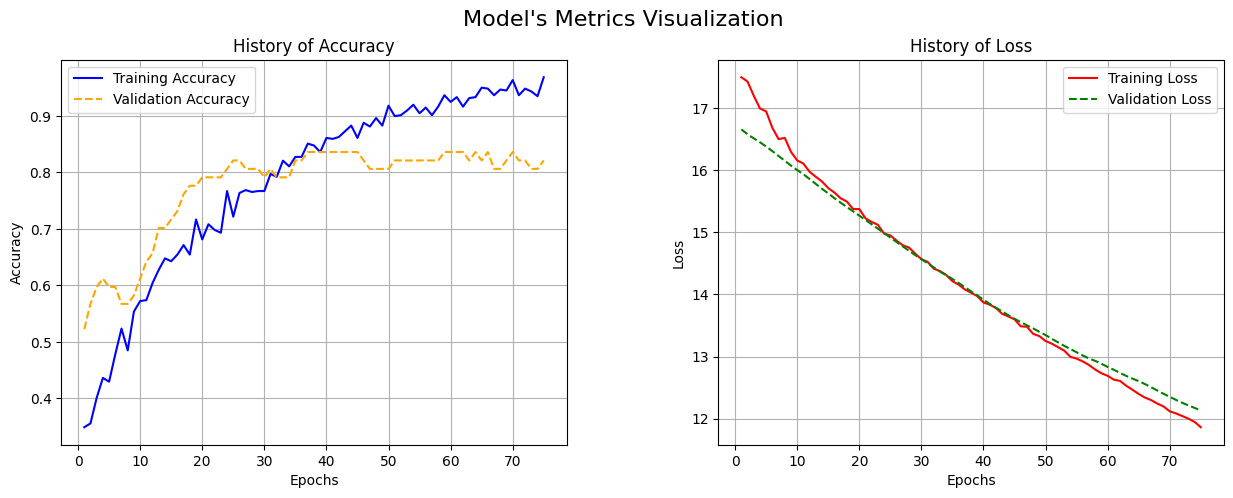

<Figure size 800x600 with 0 Axes>

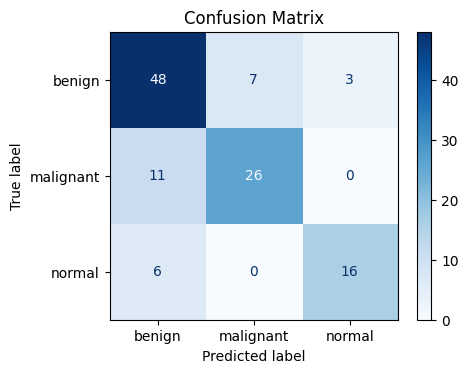

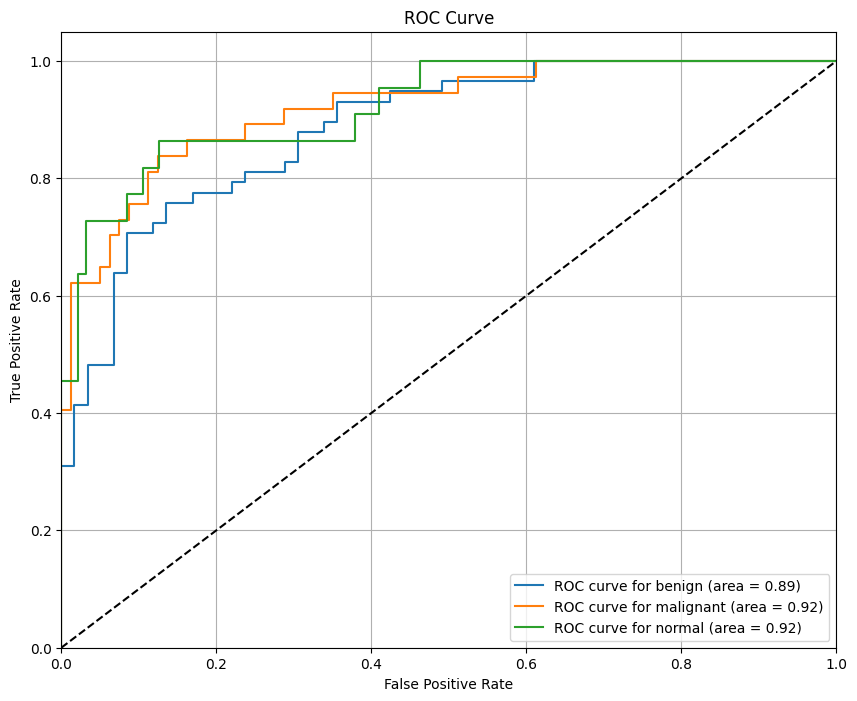

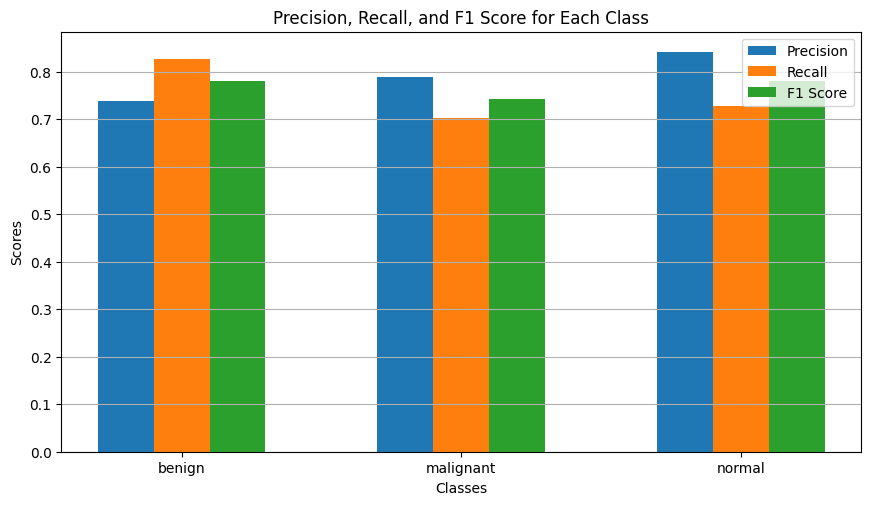

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


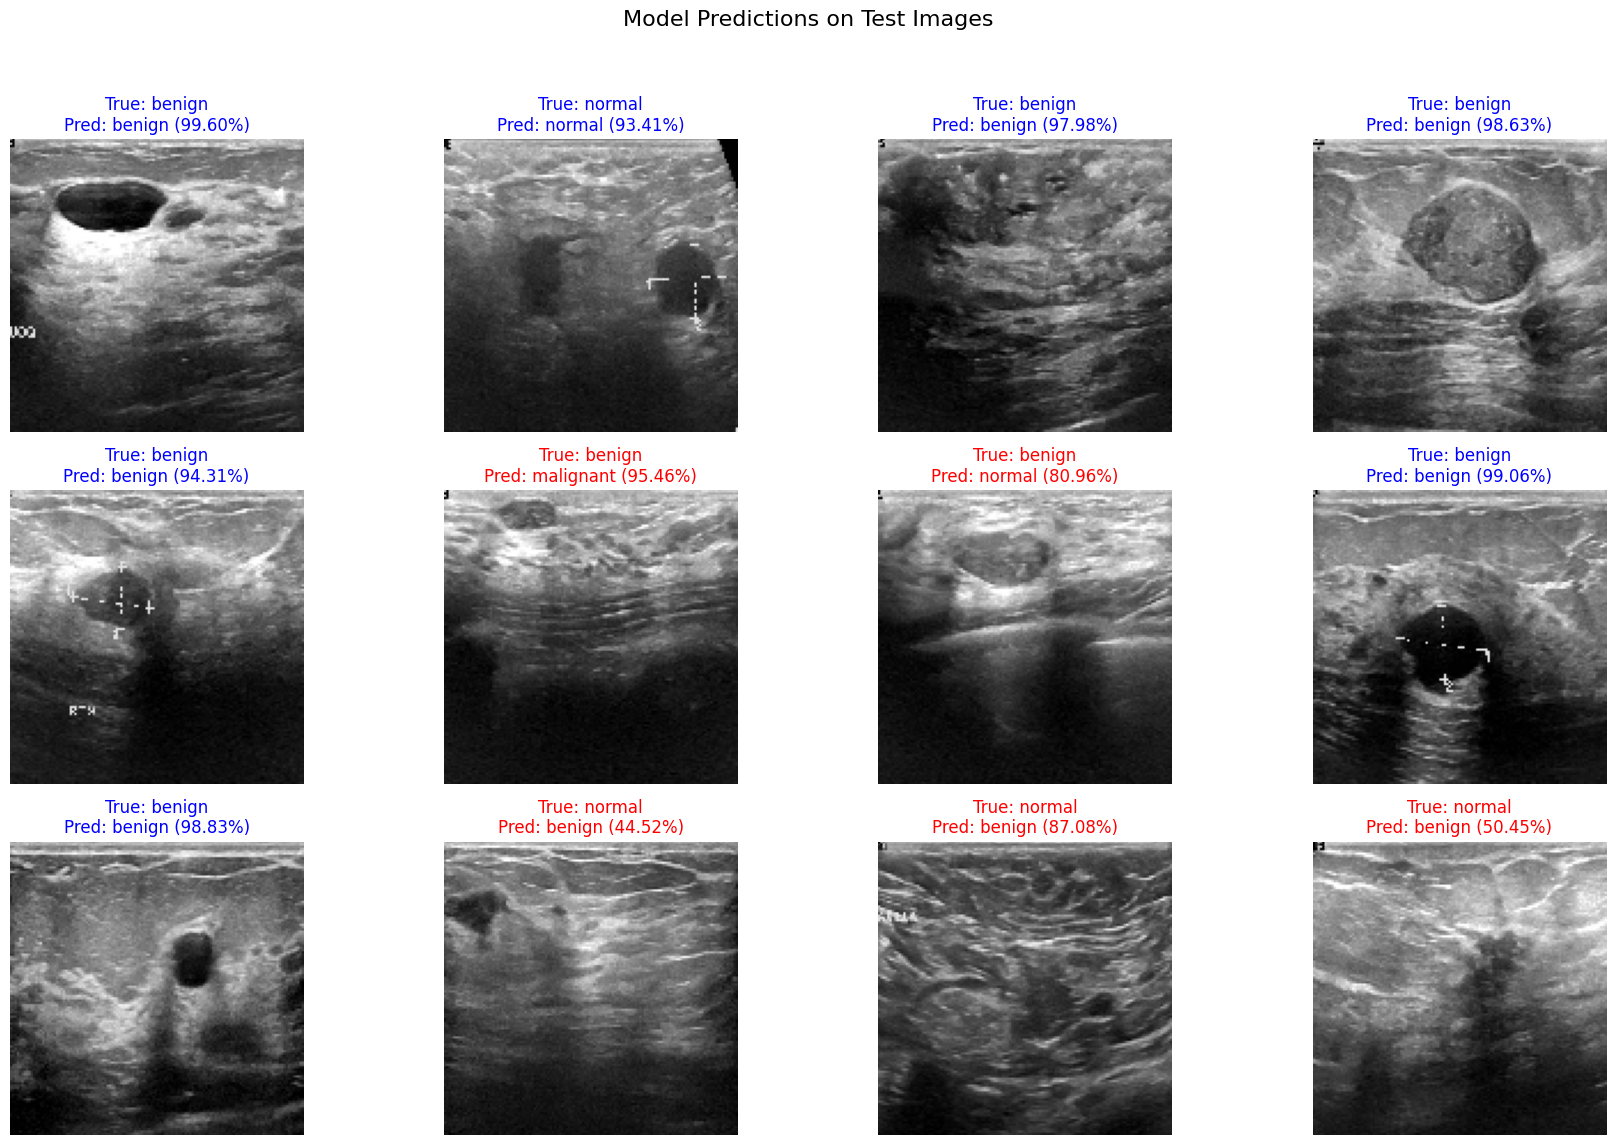

In [ ]:
# Train the model and visualize performance
fit_evaluate(model, x_train, y_train, x_test, y_test, bs=64, Epochs=75, patience=4)

# Call the function to visualize predictions on a subset of test images
visualize_model_performance(model, x_test, y_test)